# This file constructs the polariton measurements of the 1D best-performing structure

In [ ]:
import numpy as np
from contextlib import contextmanager

@contextmanager
def assign_variables(**kwargs):
    """
    Yield the values of kwargs as a tuple, in the same order
    they were passed in (Python 3.6+ preserves kwargs order). 

    Usage:
        with assign_variables(x=10, y=20) as (x, y):
            print(x, y)  # 10 20
    """
    # Grab the values in insertion order (guaranteed from Python 3.6+). :contentReference[oaicite:0]{index=0}
    values = tuple(kwargs.values())
    try:
        yield values
    finally:
        # No cleanup needed—locals created by the `as` clause
        # will simply go out of scope when the block ends.
        pass

def interpolate_dataset(data, extend=0, poly_order=1):
    """
    Interpolate a dataset of (x,y) pairs, where x are integers, using polynomial interpolation.
    
    Args:
        data: List of (x,y) tuples where x are integers
        extend: Number of points to extend beyond max(x)
        poly_order: Order of the polynomial to use for interpolation (1=linear, 2=quadratic, etc.)
                    Will automatically reduce order if not enough points are available
    
    Returns:
        List of (x,y) tuples with interpolated and extended values
    """
    # Sort data by x values
    sorted_data = sorted(data, key=lambda point: point[0])
    
    # Extract x and y values
    x_values = [point[0] for point in sorted_data]
    y_values = [point[1] for point in sorted_data]
    
    # Find min and max x values
    min_x = min(x_values)
    max_x = max(x_values)
    
    # Create a dictionary from original data for easy lookup
    data_dict = {x: y for x, y in sorted_data}
    
    # Ensure we have enough points for the polynomial order
    actual_poly_order = min(poly_order, len(sorted_data) - 1)
    if actual_poly_order != poly_order:
        print(f"Warning: Reduced polynomial order from {poly_order} to {actual_poly_order} due to insufficient data points")
    
    result = []
    
    # If we have enough points for polynomial interpolation
    if len(sorted_data) > 1:
        if actual_poly_order == 1:
            # Linear interpolation (original method)
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    result.append((x, data_dict[x]))
                else:
                    # Find closest points before and after x
                    left_idx = 0
                    while left_idx < len(x_values) - 1 and x_values[left_idx + 1] <= x:
                        left_idx += 1
                    
                    right_idx = len(x_values) - 1
                    while right_idx > 0 and x_values[right_idx - 1] >= x:
                        right_idx -= 1
                    
                    # Interpolate y value
                    x1, y1 = x_values[left_idx], y_values[left_idx]
                    x2, y2 = x_values[right_idx], y_values[right_idx]
                    
                    y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
                    result.append((x, y))
        else:
            # Polynomial interpolation
            coeffs = np.polyfit(x_values, y_values, actual_poly_order)
            
            # Interpolate for all integer points
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    # Use original data point if available
                    result.append((x, data_dict[x]))
                else:
                    # Use polynomial to interpolate
                    y = np.polyval(coeffs, x)
                    result.append((x, y))
    else:
        # Just one point, can't interpolate
        result = sorted_data.copy()
    
    # Extend beyond max_x if requested (always using linear extension)
    if extend > 0 and len(x_values) >= 2:
        # Get the last two points to determine the slope for extension
        second_to_last_x = x_values[-2]
        second_to_last_y = y_values[-2]
        last_x = x_values[-1]
        last_y = y_values[-1]
        
        # Calculate slope
        slope = (last_y - second_to_last_y) / (last_x - second_to_last_x)
        
        # Add extended points
        for i in range(1, extend + 1):
            x = max_x + i
            y = last_y + slope * i
            result.append((x, y))
    
    return result

import os
import sys

import matplotlib.pyplot as plt
import S4
from tqdm import tqdm
import torch
sys.path.append('../trials')
import ff
import secrets
import string

config = {
    "seeds": {
        "numpy": int(41),
    },
    "incidence_angle": float(0),
    "image_harmonics": int(361),
    "polarization_angle": float(0)
}
wavelengths = torch.linspace(.22, 5, 4781)
i_wavelength = 781
wavelength = 1.001
L=1.1
S = S4.New(Lattice = ((L, 0), (0, L)), NumBasis=config['image_harmonics'])

S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
S.SetMaterial(Name='W', Epsilon=(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='AlN', Epsilon=(ff.aln_n[i_wavelength])**2)
S.AddLayer(Name = 'VacuumAbove', Thickness = .5, Material = 'Vacuum')
# S.AddLayer(Name = 'Grid0', Thickness = .5, Material = 'Vacuum')
S.AddLayer(Name = 'Grid', Thickness = 1.6, Material = 'Vacuum') #2.2

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.5*L, .5*L), Halfwidths = (.05*L, .5*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.62*L, .5*L), Halfwidths = (.05*L, .5*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.74*L, .5*L), Halfwidths = (.05*L, .5*L), Angle = 0)

S.AddLayer(Name = 'Substrate', Thickness = .473, Material = 'AlN')
S.AddLayer(Name = 'Absorber', Thickness = 1, Material = 'W')
S.SetFrequency(1 / wavelength)
S.SetExcitationPlanewave(IncidenceAngles=(config['incidence_angle'], 0), sAmplitude=np.cos(config['polarization_angle']*np.pi/180), pAmplitude=np.sin(config['polarization_angle']*np.pi/180), Order=0)
(forw, back) = S.GetPowerFlux(Layer = 'VacuumAbove', zOffset = 0)

x_space = np.linspace(0, L, 50)
y_pt = .5
z_min = 0
z_max = 1.6 + .473 + 1 + .5
z_space = np.linspace(z_min, z_max, 100)

magnetic_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        _, H = S.GetFields(x, y_pt, z)  # y is 0
        magnetic_field[zi, xi, :] = np.array(H)
magnetic_field_magnitude = np.sum(np.abs(magnetic_field)**2, axis=2)
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        E, _ = S.GetFields(x, y_pt, z)  # y is 0
        electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)
import matplotlib.patches as patches
plt.figure(figsize=(12, 5))
background = np.abs(magnetic_field[:, :, 1])**2
levels = np.linspace(np.min(background), np.max(background), 100)
cf1 = plt.contourf(x_space, z_space, background, levels=levels, cmap='hot')
plt.xlabel("x (nm)", fontsize=18)
plt.ylabel("z (nm)", fontsize=18)

plt.xlim(x_space[0], x_space[-1])
plt.xticks(np.arange(0,.7,.1), np.arange(0, 700, 100))

# plt.axhline(y=.5+block_height+current_aln_thickness, color='green', linestyle='--', linewidth=1.5)
# w_box = patches.Rectangle((.3 - block_width, .5), block_width*2, block_height, fill=False, edgecolor='green', linewidth=1.5)
ax = plt.gca()
# ax.add_patch(w_box)

cbar = plt.colorbar(cf1)
cbar.set_label(r"$|H_y/H_{inc}|^2$", fontsize=12)

dz = z_space[1] - z_space[0]
dx = x_space[1] - x_space[0]
curlH = np.zeros_like(magnetic_field, dtype = complex)

dHx_dz, dHx_dx = np.gradient(magnetic_field[...,0], dz, dx, axis=(0,1))
dHy_dz, dHy_dx = np.gradient(magnetic_field[...,1], dz, dx, axis=(0,1))
dHz_dz, dHz_dx = np.gradient(magnetic_field[...,2], dz, dx, axis=(0,1))

curlH[...,0] = -dHy_dz
curlH[...,1] = dHx_dz - dHz_dx
curlH[...,2] = -dHy_dx

omega = 2 * np.pi * 1 / wavelength.item()
eps0 = 8.854187817e-12
eps = np.ones(shape = (z_space.shape[0], x_space.shape[0], 3))
for iz, z in enumerate(z_space):
    if z > 0 and z < 1:
        eps[iz,:] *= np.real((ff.w_n[i_wavelength])**2)
    elif z > 1 and z < 1 + .473:
        eps[iz,:] *= np.real((ff.aln_n[i_wavelength])**2)
    elif z > 1 + current_aln_thickness and z < 1 + current_aln_thickness + block_height:
        for ix, x in enumerate(x_space):
            if x > .3 - block_width/2 and x < .3 + block_width/2:
                eps[iz,ix,:] *= np.real((ff.w_n[i_wavelength])**2)

J = curlH - 1j * omega * eps0 * eps * electric_field
skip = 4
Z, X = np.meshgrid(z_space, x_space, indexing='ij')

plt.quiver(X[::skip, ::skip],
           Z[::skip, ::skip],
           np.real(J[::skip, ::skip, 0]),  # Jx
           np.real(J[::skip, ::skip, 2]),  # Jz
           color='white', scale=1e3)

plt.plot();

perm = np.zeros((len(z_space), len(x_space)))
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        perm[zi, xi] = np.real(S.GetEpsilon(x, y_pt, z))  # y is 0
plt.figure(figsize=(12, 5))
contour = plt.contourf(x_space, z_space, perm, levels = np.linspace(np.min(perm), np.max(perm), 100), cmap = 'hot')
plt.colorbar(contour, label='Permittivity ε')
plt.xlim(x_space[0], x_space[-1])
plt.xlabel('x')
plt.ylabel('z')
plt.xticks(np.arange(0,.7,.1), np.arange(0, 700, 100))
plt.axhline(y=.5+block_height+current_aln_thickness, color='green', linestyle='--', linewidth=1.5)
plt.axhline(y=.5+block_height, color='white', linestyle='--', linewidth=1.5)
w_box = patches.Rectangle((.3 - block_width, .5), block_width*2, block_height, 
                             fill=False, edgecolor='green', linewidth=1.5)
ax = plt.gca()
ax.add_patch(w_box)
plt.plot();

In [3]:
emissivity = torch.load('../logs/exw-dual-slit-1/emit.pt')

/tmp/ipykernel_540251/3037622974.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emissivity = torch.load('../logs/exw-dual-slit-1/emit.pt')


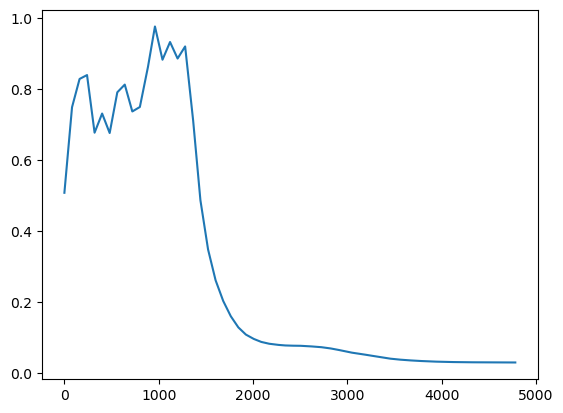

In [5]:
plt.plot(emissivity.numpy())

In [70]:
config = {
    "seeds": {
        "numpy": int(41),
    },
    "incidence_angle": float(0),
    "image_harmonics": int(361),
    "polarization_angle": float(45)
}
wavelengths = torch.linspace(.22, 5, 4781)
i_wavelength = 2001-220
wavelength = 2.001
# L=.8
L = 1.0
S = S4.New(Lattice = ((L, 0), (0, L)), NumBasis=config['image_harmonics'])

S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
S.SetMaterial(Name='W', Epsilon=(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='AlN', Epsilon=(ff.aln_n[i_wavelength])**2)
S.AddLayer(Name = 'VacuumAbove', Thickness = .5, Material = 'Vacuum')
# S.AddLayer(Name = 'Grid0', Thickness = .3, Material = 'Vacuum')

# S.SetRegionCircle('Grid0', 'AlN', (.5*L, .5*L), .2*L)
# S.SetRegionCircle('Grid0', 'Vacuum', (.5*L, .5*L), (.2-.07)*L)

S.AddLayer(Name = 'Grid', Thickness = .1, Material = 'Vacuum') #2.2

r0 = .2
tW = .07
gap = .03
N = 3

for i in range(N, 0, -1):
    S.SetRegionCircle('Grid', 'W',
                    (.5*L, .5*L),
                    (i*(tW+gap) + r0)*L)
    S.SetRegionCircle('Grid', 'Vacuum',
                    (.5*L, .5*L),
                    (i*(tW+gap) - tW + r0)*L)

# S.SetRegionRectangle('Grid', 'W', (.5*L, .5*L), Halfwidths = (.4*L, .4*L), Angle = 45)

S.AddLayer(Name = 'Substrate', Thickness = .473, Material = 'AlN')
S.AddLayer(Name = 'Absorber', Thickness = 1, Material = 'W')
S.SetFrequency(1 / wavelength)
S.SetExcitationPlanewave(IncidenceAngles=(config['incidence_angle'], 0), sAmplitude=np.cos(config['polarization_angle']*np.pi/180), pAmplitude=np.sin(config['polarization_angle']*np.pi/180), Order=0)
(forw, back) = S.GetPowerFlux(Layer = 'VacuumAbove', zOffset = 0)
print(1-np.abs(back))

0.24396221622351644


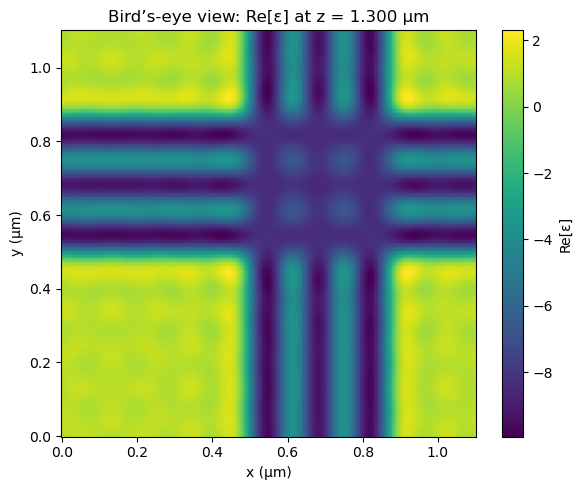

In [72]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../trials')
import ff
import S4

def build_structure(config):
    """
    Build the S4 structure exactly as in your simulation code.
    Returns the S4 object.
    """
    L  = 1.1
    L1 = 1.1
    S = S4.New(Lattice = ((L1, 0), (0, L1)),
               NumBasis = config["image_harmonics"])
    
    # Materials
    S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
    # we pick an arbitrary wavelength index here since we only need geometry
    i_wavelength = 0  
    S.SetMaterial(Name='W',    Epsilon=(ff.w_n[i_wavelength])**2)
    S.SetMaterial(Name='AlN',  Epsilon=(ff.aln_n[i_wavelength])**2)
    
    # Layers
    S.AddLayer(Name='VacuumAbove', Thickness = 0.5,  Material='Vacuum')
    S.AddLayer(Name='Grid',        Thickness = 1.6,  Material='Vacuum')
    S.AddLayer(Name='Substrate',   Thickness = 0.473,Material='AlN')
    S.AddLayer(Name='Absorber',    Thickness = 1.0,  Material='W')
    
    # Grid‐layer pattern: vertical bars
    for cx in [0.5*L1, 0.62*L1, 0.74*L1]:
        S.SetRegionRectangle(Layer='Grid',
                             Material='W',
                             Center=(cx, 0.5*L1),
                             Halfwidths=(0.05*L, 0.5*L),
                             Angle=0)
    # Horizontal bars, three rows
    rows = [0.5*L1, 0.62*L1, 0.74*L1]
    edge = 0.5 + 0.05 + 0.02 + 0.1 + 0.02 + 0.1
    for y0 in rows:
        # left wide bar
        S.SetRegionRectangle('Grid', 'W',
                             Center=(0.225*L1, y0),
                             Halfwidths=(0.225*L, 0.05*L), Angle=0)
        # two thin bars near center
        for dx in [(0.5+0.05+0.01)*L1, (0.5+0.05+0.02+0.1+0.01)*L1]:
            S.SetRegionRectangle('Grid', 'W',
                                 Center=(dx, y0),
                                 Halfwidths=(0.01*L, 0.05*L), Angle=0)
        # right wide bar
        S.SetRegionRectangle('Grid', 'W',
                             Center=((1+edge)/2*L1, y0),
                             Halfwidths=((1-edge)/2*L, 0.05*L), Angle=0)
    return S, L1

def sample_birdseye(S, L1, z0, nx=300, ny=300):
    """
    Sample Re[ε(x,y,z0)] on a uniform grid in [0,L1]×[0,L1].
    Returns xgrid, ygrid, eps_map.
    """
    x = np.linspace(0, L1, nx)
    y = np.linspace(0, L1, ny)
    eps_map = np.zeros((ny, nx), dtype=complex)
    for iy, yy in enumerate(y):
        for ix, xx in enumerate(x):
            eps_map[iy, ix] = S.GetEpsilon(xx, yy, z0)
    return x, y, eps_map

def plot_map(x, y, eps_map, z0):
    """
    Plot the real part of ε as a colormesh.
    """
    plt.figure(figsize=(6, 5))
    plt.pcolormesh(x, y, np.real(eps_map),
                   shading='auto',
                   cmap='viridis')
    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Bird’s-eye view: Re[ε] at z = {z0:.3f} μm')
    plt.colorbar(label='Re[ε]')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Configuration (must match your sim)
    config = {
        "image_harmonics": 361
    }
    # Build structure and sample
    S, L1 = build_structure(config)
    
    # Choose z0 in the middle of the Grid layer:
    # Grid layer spans z = 0.5 .. 0.5+1.6
    z0 = 0.5 + 1.6/2
    
    x, y, eps_map = sample_birdseye(S, L1, z0,
                                    nx=300, ny=300)
    plot_map(x, y, eps_map, z0)


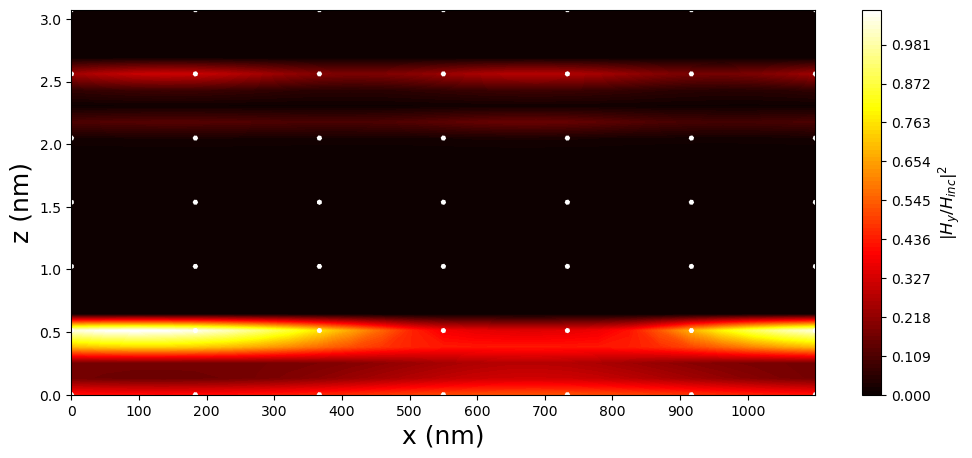

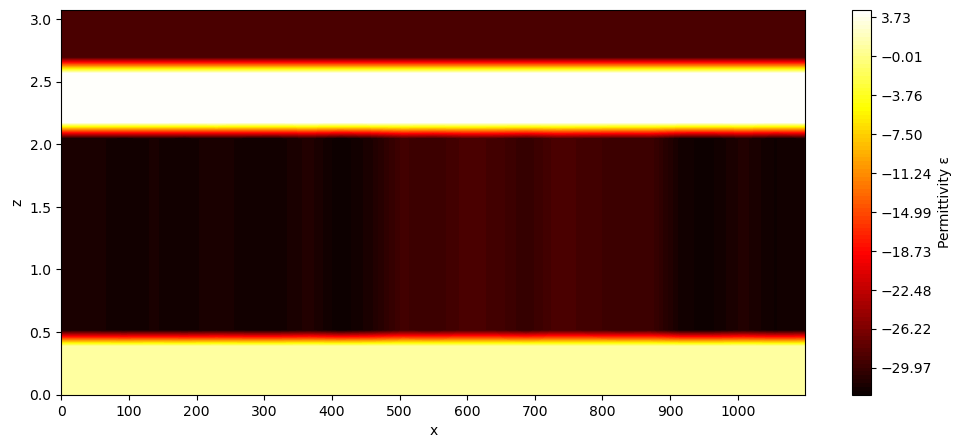

In [85]:
"""
This file simulates trials of the trilayer structure with different width, height, and thickness parameters
"""


import json
import os
import sys
import time
from pathlib import Path

import ff
import matplotlib.pyplot as plt
import numpy as np
import S4
import torch
from tqdm import tqdm
import gc

config = {
    "seeds": {
        "torch": int(52),
        "numpy": int(41)
    },
    "incidence_angle": float(0),
    "image_harmonics": int(361),
    "polarization_angle": float(45),
}

L=L1=1.1
wavelengths = torch.linspace(.22, 5, 4781)

i_wavelength = 1700-220
wavelength = wavelengths[i_wavelength]
S = S4.New(Lattice = ((L, 0), (0, L)), NumBasis=config['image_harmonics'])
S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
S.SetMaterial(Name='W', Epsilon=(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='W2', Epsilon=-(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='AlN', Epsilon=(ff.aln_n[i_wavelength])**2)
S.AddLayer(Name = 'VacuumAbove', Thickness = .5, Material = 'Vacuum')
S.AddLayer(Name = 'Grid', Thickness = 1.6, Material = 'Vacuum') #2.2

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.5*L1, .5*L1), Halfwidths = (.05*L, .5*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.62*L1, .5*L1), Halfwidths = (.05*L, .5*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.74*L1, .5*L1), Halfwidths = (.05*L, .5*L), Angle = 0)

edge = .5+.05+.02+.1+.02+.1
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.225*L1, .5*L1), Halfwidths = (.225*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.01)*L1, .5*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.02+.1+.01)*L1, .5*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((1+edge)/2*L1, .5*L1), Halfwidths = ((1-edge)/2*L, .05*L), Angle = 0)

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.225*L1, .62*L1), Halfwidths = (.225*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.01)*L1, .62*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.02+.1+.01)*L1, .62*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((1+edge)/2*L1, .62*L1), Halfwidths = ((1-edge)/2*L, .05*L), Angle = 0)

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.225*L1, .74*L1), Halfwidths = (.225*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.01)*L1, .74*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.02+.1+.01)*L1, .74*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((1+edge)/2*L1, .74*L1), Halfwidths = ((1-edge)/2*L, .05*L), Angle = 0)

S.AddLayer(Name = 'Substrate', Thickness = .473, Material = 'AlN')
S.AddLayer(Name = 'Absorber', Thickness = 1, Material = 'W')
S.SetFrequency(1 / wavelength)
S.SetExcitationPlanewave(IncidenceAngles=(config['incidence_angle'], 0), sAmplitude=np.cos(config['polarization_angle']*np.pi/180), pAmplitude=np.sin(config['polarization_angle']*np.pi/180), Order=0) # In the real simulation this should be edited to have 1/sqrt(2) amplitude in both directions

# Pasted code END -----------------------------------
# Code to be edited START ---------------------------

x_space = np.linspace(0, L, 25)
y_pt = .61 * L
z_min = 0
z_max = 1.6+.473+1
z_space = np.linspace(z_min, z_max, 25)

magnetic_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        _, H = S.GetFields(x, y_pt, z)  # y is 0
        magnetic_field[zi, xi, :] = np.array(H)
magnetic_field_magnitude = np.sum(np.abs(magnetic_field)**2, axis=2)
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        E, _ = S.GetFields(x, y_pt, z)  # y is 0
        electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)
import matplotlib.patches as patches
plt.figure(figsize=(12, 5))
background = np.abs(magnetic_field[:, :, 1])**2
levels = np.linspace(np.min(background), np.max(background), 100)
cf1 = plt.contourf(x_space, z_space, background, levels=levels, cmap='hot')
plt.xlabel("x (nm)", fontsize=18)
plt.ylabel("z (nm)", fontsize=18)

plt.xlim(x_space[0], x_space[-1])
plt.xticks(np.arange(0,L,.1), np.arange(0,int(L*1000), 100))

ax = plt.gca()

cbar = plt.colorbar(cf1)
cbar.set_label(r"$|H_y/H_{inc}|^2$", fontsize=12)

dz = z_space[1] - z_space[0]
dx = x_space[1] - x_space[0]
curlH = np.zeros_like(magnetic_field, dtype = complex)

dHx_dz, dHx_dx = np.gradient(magnetic_field[...,0], dz, dx, axis=(0,1))
dHy_dz, dHy_dx = np.gradient(magnetic_field[...,1], dz, dx, axis=(0,1))
dHz_dz, dHz_dx = np.gradient(magnetic_field[...,2], dz, dx, axis=(0,1))

curlH[...,0] = -dHy_dz
curlH[...,1] = dHx_dz - dHz_dx
curlH[...,2] = -dHy_dx

omega = 2 * np.pi * 1 / wavelength.item()
eps0 = 8.854187817e-12
eps = np.ones(shape = (z_space.shape[0], x_space.shape[0], 3))
for iz, z in enumerate(z_space):
    if z > 0 and z < 1:
        eps[iz,:] *= np.real((ff.w_n[i_wavelength])**2)
    elif z > 1 and z < 1 + .473:
        eps[iz,:] *= np.real((ff.aln_n[i_wavelength])**2)
    elif z > 1 + .473 and z < 1 + .473 + 1.6:
        for ix, x in enumerate(x_space):
            if (x > (.5-.05)*L and x < (.5 + .05)*L) or (x > (.62-.05)*L and x < (.62 + .05)*L) or (x > (.74-.05)*L and x < (.74 + .05)*L):
                eps[iz,ix] *= np.real(ff.w_n[i_wavelength]**2)

J = curlH - 1j * omega * eps0 * eps * electric_field
skip = 4
Z, X = np.meshgrid(z_space, x_space, indexing='ij')

plt.quiver(X[::skip, ::skip],
           Z[::skip, ::skip],
           np.real(J[::skip, ::skip, 0]),  # Jx
           np.real(J[::skip, ::skip, 2]),  # Jz
           color='white', scale=1e3)

plt.plot();

perm = np.zeros((len(z_space), len(x_space)))
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        perm[zi, xi] = np.real(S.GetEpsilon(x, y_pt, z))  # y is 0
plt.figure(figsize=(12, 5))
contour = plt.contourf(x_space, z_space, perm, levels = np.linspace(np.min(perm), np.max(perm), 100), cmap = 'hot')
plt.colorbar(contour, label='Permittivity ε')
plt.xlim(x_space[0], x_space[-1])
plt.ylim(z_space[0], z_space[-1])
plt.xlabel('x')
plt.ylabel('z')
plt.xticks(np.arange(0,L,.1), np.arange(0, int(L*1000), 100))
ax = plt.gca()
plt.plot();

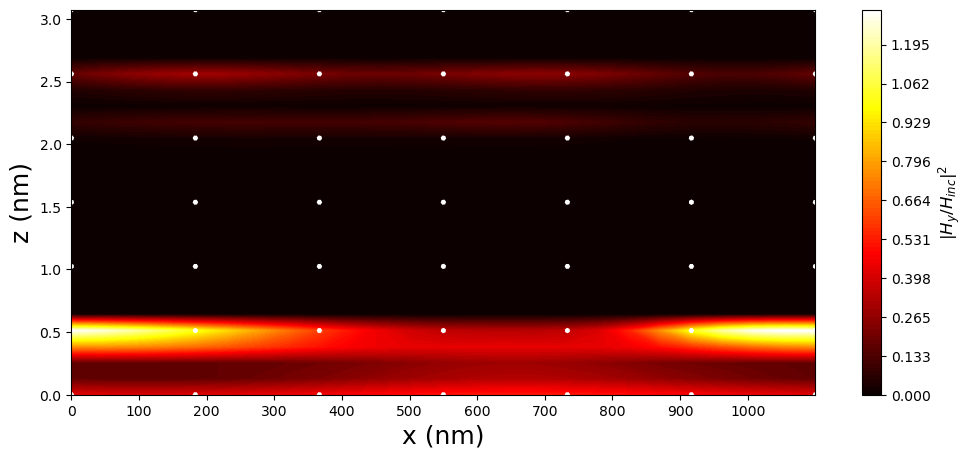

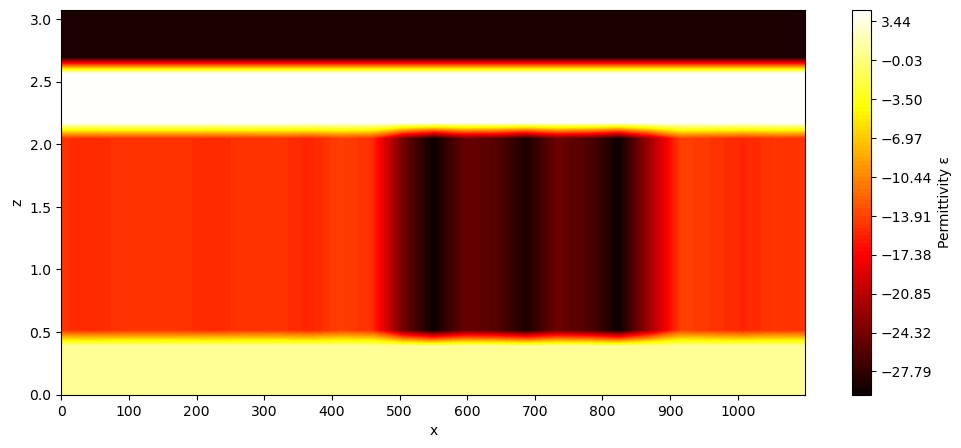

In [86]:
"""
This file simulates trials of the trilayer structure with different width, height, and thickness parameters
"""


import json
import os
import sys
import time
from pathlib import Path

import ff
import matplotlib.pyplot as plt
import numpy as np
import S4
import torch
from tqdm import tqdm
import gc

config = {
    "seeds": {
        "torch": int(52),
        "numpy": int(41)
    },
    "incidence_angle": float(0),
    "image_harmonics": int(361),
    "polarization_angle": float(45),
}

L=L1=1.1
wavelengths = torch.linspace(.22, 5, 4781)

i_wavelength = 1700-220
wavelength = wavelengths[i_wavelength]
S = S4.New(Lattice = ((L, 0), (0, L)), NumBasis=config['image_harmonics'])
S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
S.SetMaterial(Name='W', Epsilon=(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='W2', Epsilon=-(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='AlN', Epsilon=(ff.aln_n[i_wavelength])**2)
S.AddLayer(Name = 'VacuumAbove', Thickness = .5, Material = 'Vacuum')
S.AddLayer(Name = 'Grid', Thickness = 1.6, Material = 'Vacuum') #2.2

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.5*L1, .5*L1), Halfwidths = (.05*L, .5*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.62*L1, .5*L1), Halfwidths = (.05*L, .5*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.74*L1, .5*L1), Halfwidths = (.05*L, .5*L), Angle = 0)

edge = .5+.05+.02+.1+.02+.1
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.225*L1, .5*L1), Halfwidths = (.225*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.01)*L1, .5*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.02+.1+.01)*L1, .5*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((1+edge)/2*L1, .5*L1), Halfwidths = ((1-edge)/2*L, .05*L), Angle = 0)

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.225*L1, .62*L1), Halfwidths = (.225*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.01)*L1, .62*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.02+.1+.01)*L1, .62*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((1+edge)/2*L1, .62*L1), Halfwidths = ((1-edge)/2*L, .05*L), Angle = 0)

S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.225*L1, .74*L1), Halfwidths = (.225*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.01)*L1, .74*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((.5+.05+.02+.1+.01)*L1, .74*L1), Halfwidths = (.01*L, .05*L), Angle = 0)
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = ((1+edge)/2*L1, .74*L1), Halfwidths = ((1-edge)/2*L, .05*L), Angle = 0)

S.AddLayer(Name = 'Substrate', Thickness = .473, Material = 'AlN')
S.AddLayer(Name = 'Absorber', Thickness = 1, Material = 'W')
S.SetFrequency(1 / wavelength)
S.SetExcitationPlanewave(IncidenceAngles=(config['incidence_angle'], 0), sAmplitude=np.cos(config['polarization_angle']*np.pi/180), pAmplitude=np.sin(config['polarization_angle']*np.pi/180), Order=0) # In the real simulation this should be edited to have 1/sqrt(2) amplitude in both directions

# Pasted code END -----------------------------------
# Code to be edited START ---------------------------

x_space = np.linspace(0, L, 25)
y_pt = .56 * L
z_min = 0
z_max = 1.6+.473+1
z_space = np.linspace(z_min, z_max, 25)

magnetic_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        _, H = S.GetFields(x, y_pt, z)  # y is 0
        magnetic_field[zi, xi, :] = np.array(H)
magnetic_field_magnitude = np.sum(np.abs(magnetic_field)**2, axis=2)
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        E, _ = S.GetFields(x, y_pt, z)  # y is 0
        electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)
import matplotlib.patches as patches
plt.figure(figsize=(12, 5))
background = np.abs(magnetic_field[:, :, 1])**2
levels = np.linspace(np.min(background), np.max(background), 100)
cf1 = plt.contourf(x_space, z_space, background, levels=levels, cmap='hot')
plt.xlabel("x (nm)", fontsize=18)
plt.ylabel("z (nm)", fontsize=18)

plt.xlim(x_space[0], x_space[-1])
plt.xticks(np.arange(0,L,.1), np.arange(0,int(L*1000), 100))

ax = plt.gca()

cbar = plt.colorbar(cf1)
cbar.set_label(r"$|H_y/H_{inc}|^2$", fontsize=12)

dz = z_space[1] - z_space[0]
dx = x_space[1] - x_space[0]
curlH = np.zeros_like(magnetic_field, dtype = complex)

dHx_dz, dHx_dx = np.gradient(magnetic_field[...,0], dz, dx, axis=(0,1))
dHy_dz, dHy_dx = np.gradient(magnetic_field[...,1], dz, dx, axis=(0,1))
dHz_dz, dHz_dx = np.gradient(magnetic_field[...,2], dz, dx, axis=(0,1))

curlH[...,0] = -dHy_dz
curlH[...,1] = dHx_dz - dHz_dx
curlH[...,2] = -dHy_dx

omega = 2 * np.pi * 1 / wavelength.item()
eps0 = 8.854187817e-12
eps = np.ones(shape = (z_space.shape[0], x_space.shape[0], 3))
for iz, z in enumerate(z_space):
    if z > 0 and z < 1:
        eps[iz,:] *= np.real((ff.w_n[i_wavelength])**2)
    elif z > 1 and z < 1 + .473:
        eps[iz,:] *= np.real((ff.aln_n[i_wavelength])**2)
    elif z > 1 + .473 and z < 1 + .473 + 1.6:
        for ix, x in enumerate(x_space):
            if (x > (.5-.05)*L and x < (.5 + .05)*L) or (x > (.62-.05)*L and x < (.62 + .05)*L) or (x > (.74-.05)*L and x < (.74 + .05)*L):
                eps[iz,ix] *= np.real(ff.w_n[i_wavelength]**2)

J = curlH - 1j * omega * eps0 * eps * electric_field
skip = 4
Z, X = np.meshgrid(z_space, x_space, indexing='ij')

plt.quiver(X[::skip, ::skip],
           Z[::skip, ::skip],
           np.real(J[::skip, ::skip, 0]),  # Jx
           np.real(J[::skip, ::skip, 2]),  # Jz
           color='white', scale=1e3)

plt.plot();

perm = np.zeros((len(z_space), len(x_space)))
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        perm[zi, xi] = np.real(S.GetEpsilon(x, y_pt, z))  # y is 0
plt.figure(figsize=(12, 5))
contour = plt.contourf(x_space, z_space, perm, levels = np.linspace(np.min(perm), np.max(perm), 100), cmap = 'hot')
plt.colorbar(contour, label='Permittivity ε')
plt.xlim(x_space[0], x_space[-1])
plt.ylim(z_space[0], z_space[-1])
plt.xlabel('x')
plt.ylabel('z')
plt.xticks(np.arange(0,L,.1), np.arange(0, int(L*1000), 100))
ax = plt.gca()
plt.plot();

In [87]:
J

array([[[ 1.81004850e+00-2.49243389e+00j,
          1.04514378e+00-2.69129247e+00j,
          1.30954040e-01+3.84604739e-02j],
        [ 1.83450920e+00-2.48798474e+00j,
          1.01032524e+00-2.70454006e+00j,
          9.93546205e-02+2.98361698e-02j],
        [ 1.84191020e+00-2.48677342e+00j,
          1.01303771e+00-2.70833053e+00j,
          3.42464817e-02+1.19958142e-02j],
        ...,
        [ 1.71260078e+00-2.51102769e+00j,
          9.79032478e-01-2.68928381e+00j,
          2.45188320e-01+6.89160983e-02j],
        [ 1.76895484e+00-2.50016781e+00j,
          9.92432027e-01-2.69458419e+00j,
          2.08459003e-01+5.92979740e-02j],
        [ 1.81004850e+00-2.49243389e+00j,
          9.61164140e-01-2.70836901e+00j,
          1.86427918e-01+5.34458983e-02j]],

       [[ 2.56293736e+00-2.31045715e+00j,
          1.56918701e+00-2.55431319e+00j,
          1.99288364e-01+5.08897564e-02j],
        [ 2.58229584e+00-2.31021759e+00j,
          1.53114587e+00-2.57322693e+00j,
          1.

In [89]:
import numpy as np

# ----------------------------- geometry parameters ----------------------------
L   = 0.9          # lattice constant in x and y
L1  = 1.1          # helper constant used in your script
edge = 0.5 + 0.05 + 0.02 + 0.10 + 0.02 + 0.10   # = 0.79 (same as script)

# Each tuple is (cx, cy, halfwidth_x, halfwidth_y) in the S4 coordinate system
rects = [
    # vertical stripes through the cell centre
    (.50*L, .50*L, .05*L1, .50*L),
    (.62*L, .50*L, .05*L1, .50*L),
    (.74*L, .50*L, .05*L1, .50*L),

    # three horizontal “tracks” at y = 0.50 L, 0.62 L, 0.74 L
]
# helper to populate the repeated horizontal tracks
track_ys = (.50, .62, .74)
for y in track_ys:
    rects.extend([
        (.225*L,              y*L, .225*L,        .05*L1),
        ((.5+.05+.01)*L,      y*L, .01*L,         .05*L1),
        ((.5+.05+.02+.1+.01)*L, y*L, .01*L,       .05*L1),
        (((1+edge)/2)*L,      y*L, ((1-edge)/2)*L, .05*L1)
    ])

# four tiny squares near the cell centre
rects.extend([
    (.56*L, .56*L, .01*L1, .01*L1),
    (.56*L, .68*L, .01*L1, .01*L1),
    (.68*L, .56*L, .01*L1, .01*L1),
    (.68*L, .68*L, .01*L1, .01*L1),
])

# ----------------------------- rendering routine -----------------------------
def print_topdown(grid_pts: int = 80, char_w='W', char_empty='.'):
    """ASCII preview of the tungsten pattern on an (grid_pts x grid_pts) raster."""
    xs = np.linspace(0, L, grid_pts)        # sample points along x
    ys = np.linspace(0, L, grid_pts)[::-1]  # reverse so the first line is ‘top’
    canvas = []

    for y in ys:
        row = []
        for x in xs:
            in_w = any(abs(x-cx) <= hwx and abs(y-cy) <= hwy
                       for cx, cy, hwx, hwy in rects)
            row.append(char_w if in_w else char_empty)
        canvas.append(''.join(row))
    print('\n'.join(canvas))

# ----------------------------- run preview -----------------------------------
print_topdown(grid_pts=80)       # change resolution if needed


...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
...................................WWWWWWWWWWWWWWWWWWWWWWWWWWWWW................
............................

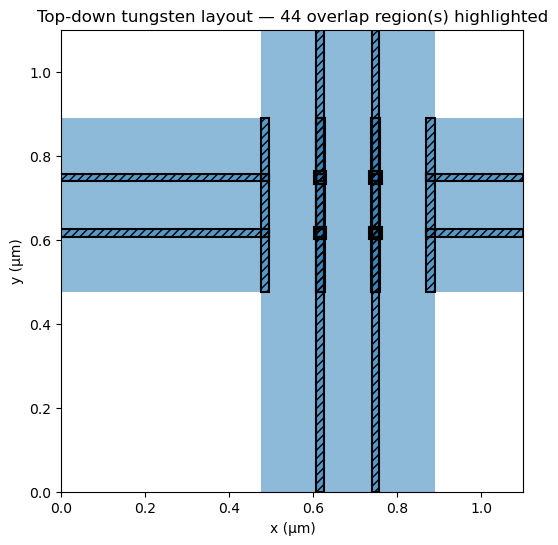

In [129]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ----------------------------- geometry parameters ----------------------------
L   = 1.1          # lattice constant
L1  = 1.5
edge = 0.5 + 0.05 + 0.02 + 0.10 + 0.02 + 0.10   # = 0.79

# helper: create list of (cx, cy, halfwidth_x, halfwidth_y)
rects = [
    # vertical stripes
    (.50*L, .50*L, .05*L1, .50*L),
    (.62*L, .50*L, .05*L1, .50*L),
    (.74*L, .50*L, .05*L1, .50*L),
]

track_ys = (.50, .62, .74)
for y in track_ys:
    rects.extend([
        (.225*L,              y*L, .225*L,        .05*L1),
        ((.5+.05+.01)*L,      y*L, .01*L,         .05*L1),
        ((.5+.05+.02+.1+.01)*L, y*L, .01*L,       .05*L1),
        (((1+edge)/2)*L,      y*L, ((1-edge)/2)*L, .05*L1)
    ])

# tiny squares
rects.extend([
    (.56*L, .56*L, .01*L1, .01*L1),
    (.56*L, .68*L, .01*L1, .01*L1),
    (.68*L, .56*L, .01*L1, .01*L1),
    (.68*L, .68*L, .01*L1, .01*L1),
])

# ----------------------------- overlap detection -----------------------------
def as_bbox(cx, cy, hwx, hwy):
    """Return bbox (xmin, xmax, ymin, ymax)."""
    return cx - hwx, cx + hwx, cy - hwy, cy + hwy

overlaps = []
for i in range(len(rects)):
    for j in range(i + 1, len(rects)):
        xmin1, xmax1, ymin1, ymax1 = as_bbox(*rects[i])
        xmin2, xmax2, ymin2, ymax2 = as_bbox(*rects[j])
        x_overlap = min(xmax1, xmax2) - max(xmin1, xmin2)
        y_overlap = min(ymax1, ymax2) - max(ymin1, ymin2)
        if x_overlap > 0 and y_overlap > 0:
            # centre and halfwidths of overlap
            cx = (max(xmin1, xmin2) + min(xmax1, xmax2)) / 2
            cy = (max(ymin1, ymin2) + min(ymax1, ymax2)) / 2
            overlaps.append((cx, cy, x_overlap / 2, y_overlap / 2))

# remove duplicate overlaps that can occur when more than two rects intersect
# convert list to set of rounded tuples to deduplicate
unique_overlaps = {tuple(round(v, 8) for v in tup) for tup in overlaps}

# ----------------------------- plotting --------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

# plot W rectangles
for cx, cy, hwx, hwy in rects:
    ax.add_patch(Rectangle((cx - hwx, cy - hwy), 2 * hwx, 2 * hwy,
                           linewidth=1, fill=True, alpha=0.5))

# plot overlaps with a hatch to highlight (no explicit color set)
for cx, cy, hwx, hwy in unique_overlaps:
    ax.add_patch(Rectangle((cx - hwx, cy - hwy), 2 * hwx, 2 * hwy,
                           linewidth=1.5, fill=False, hatch='////'))

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')
ax.set_title(f'Top‑down tungsten layout — {len(unique_overlaps)} overlap region(s) highlighted')

plt.show()


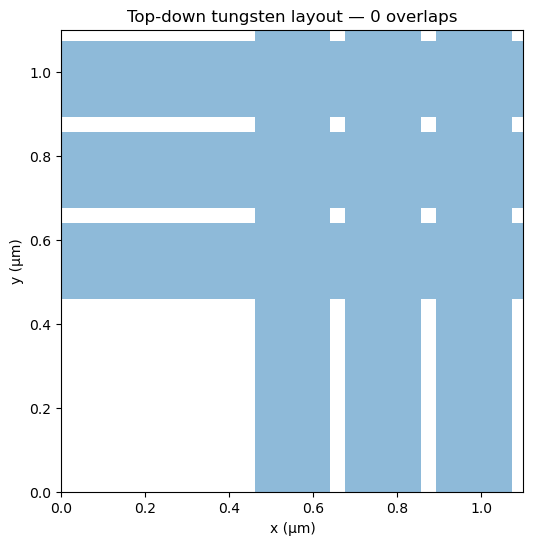

In [139]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ----------------------------- geometry parameters ----------------------------
L   = 1.1
L1  = 1.8
edge = 0.5*L + (0.05 + 0.02 + 0.05)*L1*2 + 0.05*L1

# ----------------------------- collect rectangles -----------------------------
rects = []

# Three long vertical bars
rects += [
    (0.5*L, 0.5*L, 0.05*L1, 0.5*L),
    (0.5*L + (0.05 + 0.01)*L1*2, 0.5*L, 0.05*L1, 0.5*L),
    (0.5*L + (0.05 + 0.01)*L1*4, 0.5*L, 0.05*L1, 0.5*L),
]

# Horizontal tracks at three y-positions
ys = [
    0.5*L,
    0.5*L + 2*(0.05 + 0.01)*L1,
    0.5*L + 4*(0.05 + 0.01)*L1
]

for y in ys:
    # westmost bar
    rects.append((
        (0.5*L - 0.05*L1) / 2,
        y,
        (0.5*L - 0.05*L1) / 2,
        0.05*L1
    ))
    # two small bars
    rects.append((0.5*L + (0.05 + 0.01)*L1, y, 0.01*L1, 0.05*L1))
    rects.append((0.5*L + (0.05 + 0.01)*L1*3, y, 0.01*L1, 0.05*L1))
    # eastmost bar
    rects.append(((L + edge) / 2, y, (L - edge) / 2, 0.05*L1))

# ----------------------------- overlap detection -----------------------------
def bbox(cx, cy, hwx, hwy):
    return cx - hwx, cx + hwx, cy - hwy, cy + hwy

overlaps = []
for i in range(len(rects)):
    x1a, x1b, y1a, y1b = bbox(*rects[i])
    for j in range(i + 1, len(rects)):
        x2a, x2b, y2a, y2b = bbox(*rects[j])
        x_ov = min(x1b, x2b) - max(x1a, x2a)
        y_ov = min(y1b, y2b) - max(y1a, y2a)
        if x_ov > 0 and y_ov > 0:
            cx = (max(x1a, x2a) + min(x1b, x2b)) / 2
            cy = (max(y1a, y2a) + min(y1b, y2b)) / 2
            overlaps.append((cx, cy, x_ov / 2, y_ov / 2))

unique_overlaps = {tuple(round(v, 8) for v in tup) for tup in overlaps}

# ----------------------------- plotting --------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

# plot tungsten rectangles
for cx, cy, hwx, hwy in rects:
    ax.add_patch(Rectangle((cx - hwx, cy - hwy), 2*hwx, 2*hwy,
                           linewidth=1, fill=True, alpha=0.5))

# highlight overlap regions (if any)
for cx, cy, hwx, hwy in unique_overlaps:
    ax.add_patch(Rectangle((cx - hwx, cy - hwy), 2*hwx, 2*hwy,
                           linewidth=1.5, fill=False, hatch='////'))

# axes and labels
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_title(f'Top-down tungsten layout — {len(unique_overlaps)} overlaps')

plt.show()


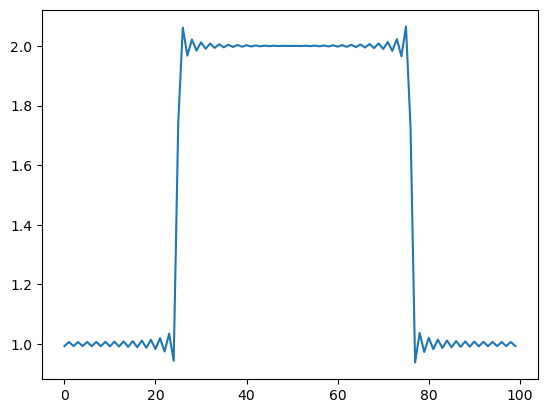

In [135]:
import S4
S = S4.New(Lattice = 1, NumBasis=100)
S.SetMaterial(Name='Metal', Epsilon=2)
S.SetMaterial(Name='Vacuum', Epsilon=1)
S.AddLayer(Name='Vacuum',Thickness=1,Material='Vacuum')
S.SetRegionRectangle(Layer = 'Vacuum', Material='Metal', Center=(.5, 0), Halfwidths=(.25,0), Angle=0)
S.SetRegionRectangle(Layer = 'Vacuum', Material='Metal', Center=(.76, 0), Halfwidths=(.01,0), Angle=0)
S.SetFrequency(1)
eps = np.zeros((100,), dtype=complex)
for ix, x in enumerate(np.linspace(0,1,100)):
    eps[ix]=S.GetEpsilon(x,0,0.5)
plt.plot(np.real(eps))

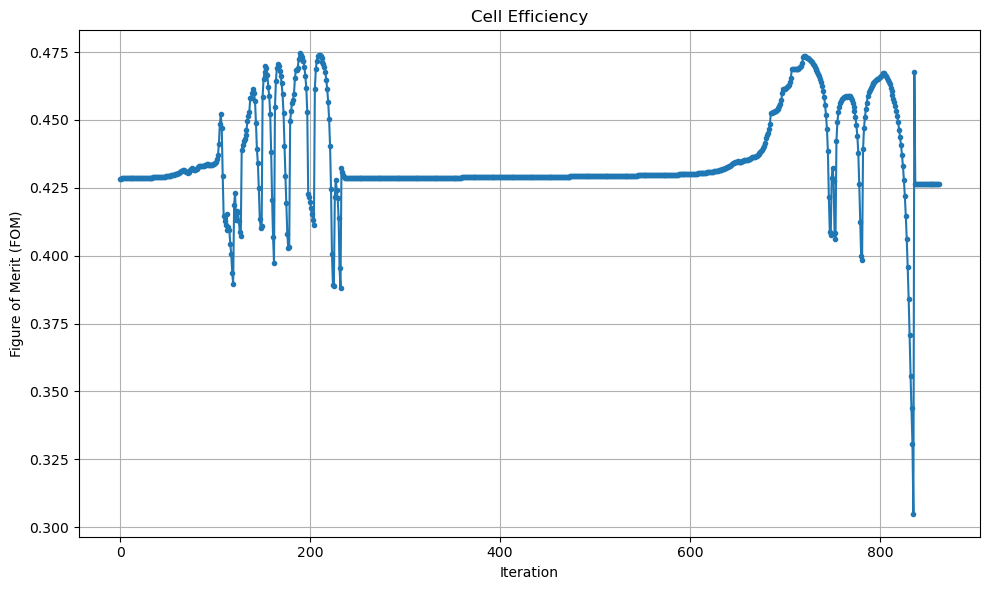

In [2]:
import matplotlib.pyplot as plt

# Path to the file
file_path = '../logs/gradient-descent-on-grating-t/def-655e42f4/fom_values.txt'

# Read values from file
with open(file_path, 'r') as file:
    fom_values = [float(line.strip()) for line in file if line.strip()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fom_values, marker='o', linestyle='-', markersize=3)
plt.title('Cell Efficiency')
plt.xlabel('Iteration')
plt.ylabel('Figure of Merit (FOM)')
plt.grid(True)
plt.tight_layout()
plt.show()


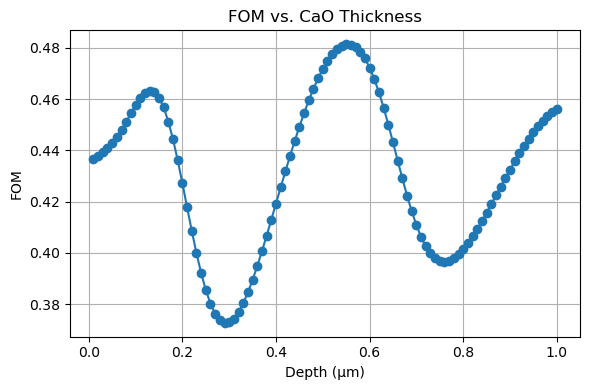

In [4]:
x = """
   1.000   0.456052
   0.990   0.454915
   0.980   0.453423
   0.970   0.451614
   0.960   0.449521
   0.950   0.447172
   0.940   0.444593
   0.930   0.441813
   0.920   0.438859
   0.910   0.435756
   0.900   0.432535
   0.890   0.429225
   0.880   0.425857
   0.870   0.422461
   0.860   0.419070
   0.850   0.415723
   0.840   0.412468
   0.830   0.409356
   0.820   0.406437
   0.810   0.403768
   0.800   0.401410
   0.790   0.399433
   0.780   0.397907
   0.770   0.396911
   0.760   0.396524
   0.750   0.396829
   0.740   0.397900
   0.730   0.399804
   0.720   0.402587
   0.710   0.406276
   0.700   0.410857
   0.690   0.416270
   0.680   0.422397
   0.670   0.429069
   0.660   0.436073
   0.650   0.443167
   0.640   0.450106
   0.630   0.456661
   0.620   0.462641
   0.610   0.467899
   0.600   0.472337
   0.590   0.475898
   0.580   0.478567
   0.570   0.480359
   0.560   0.481304
   0.550   0.481446
   0.540   0.480833
   0.530   0.479514
   0.520   0.477542
   0.510   0.474964
   0.500   0.471828
   0.490   0.468181
   0.480   0.464063
   0.470   0.459517
   0.460   0.454582
   0.450   0.449297
   0.440   0.443706
   0.430   0.437858
   0.420   0.431804
   0.410   0.425598
   0.400   0.419307
   0.390   0.413003
   0.380   0.406772
   0.370   0.400707
   0.360   0.394915
   0.350   0.389511
   0.340   0.384624
   0.330   0.380386
   0.320   0.376940
   0.310   0.374428
   0.300   0.372991
   0.290   0.372760
   0.280   0.373844
   0.270   0.376325
   0.260   0.380240
   0.250   0.385570
   0.240   0.392223
   0.230   0.400024
   0.220   0.408705
   0.210   0.417913
   0.200   0.427225
   0.190   0.436181
   0.180   0.444336
   0.170   0.451299
   0.160   0.456780
   0.150   0.460613
   0.140   0.462763
   0.130   0.463318
   0.120   0.462471
   0.110   0.460497
   0.100   0.457724
   0.090   0.454507
   0.080   0.451186
   0.070   0.448050
   0.060   0.445290
   0.050   0.442972
   0.040   0.441052
   0.030   0.439431
   0.020   0.438024
   0.010   0.436795


   """
lines = x.strip().splitlines()
import numpy as np
import matplotlib.pyplot as plt
# 2. Use numpy to load the two columns
data = np.loadtxt(lines)

# 3. Split into x and y arrays
xs = data[:, 0]
ys = data[:, 1]

# 4. Plot y vs x
plt.figure(figsize=(6, 4))
plt.plot(xs, ys, marker='o', linestyle='-')
plt.xlabel('Depth (μm)')
plt.ylabel('FOM')
plt.title('FOM vs. CaO Thickness')
plt.grid(True)
plt.tight_layout()
plt.show()


0.0 increase per step


/tmp/ipykernel_4816/598826393.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

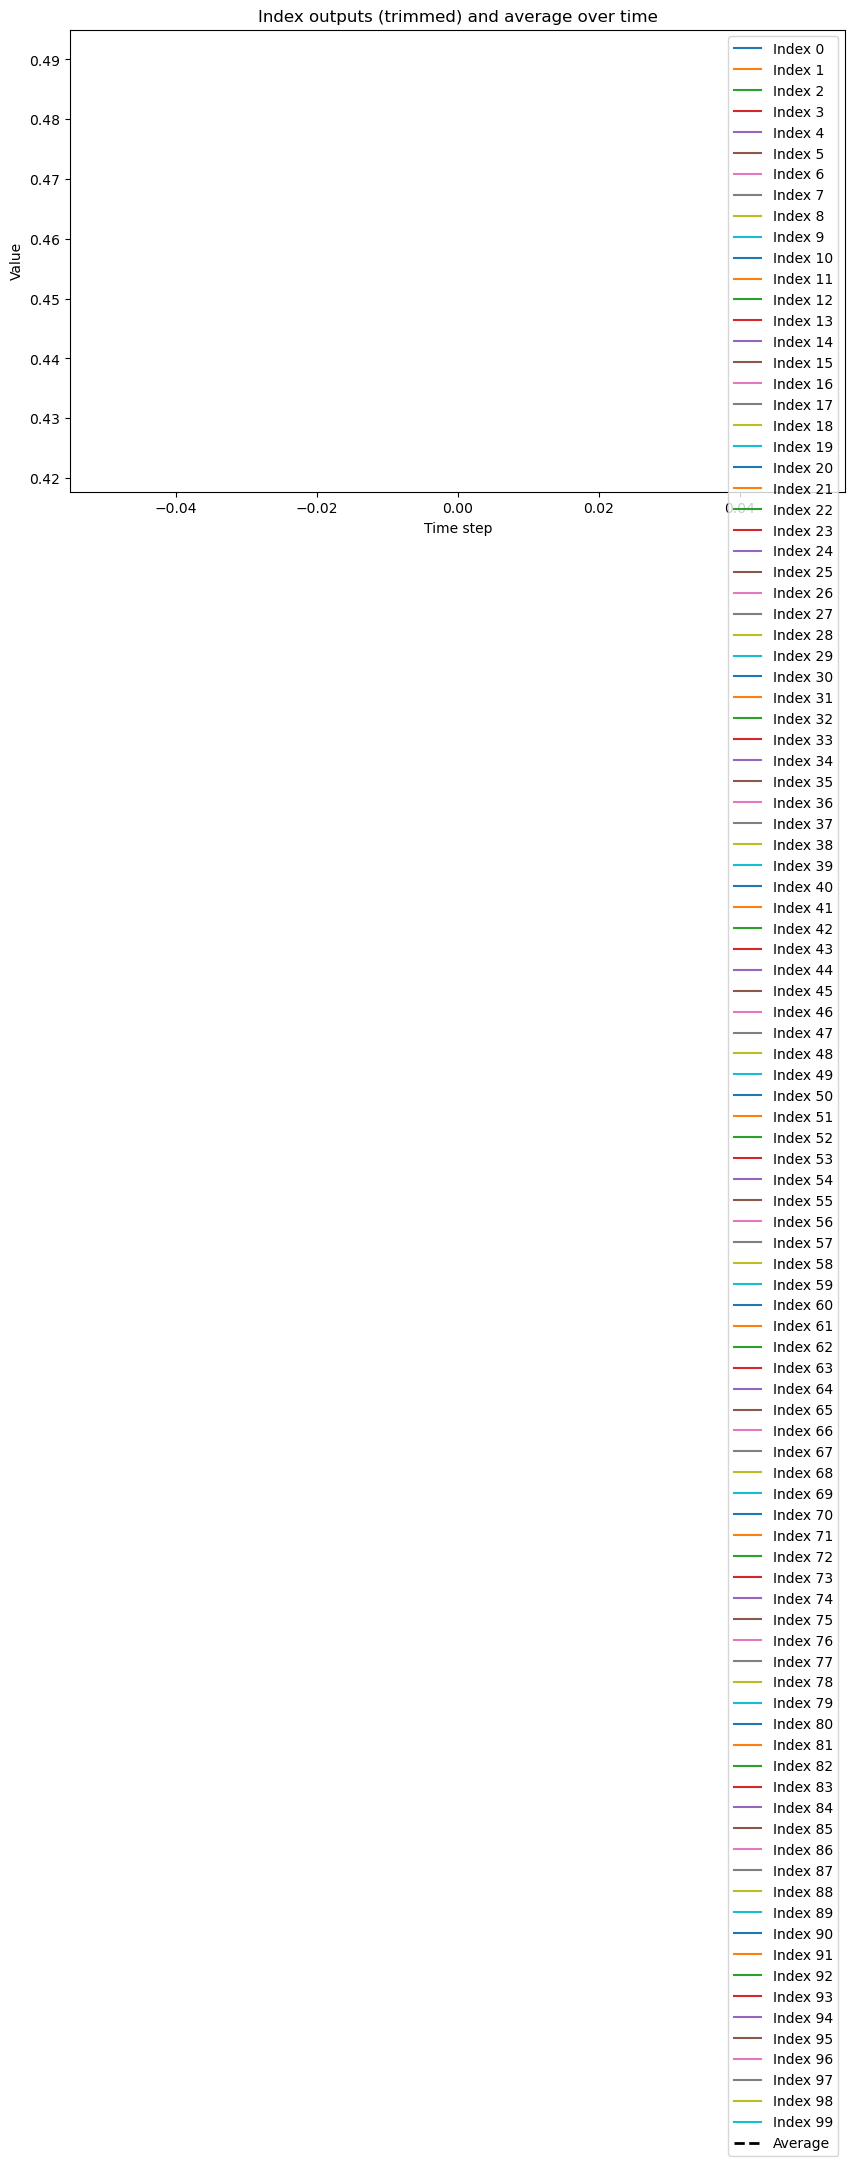

In [7]:
import matplotlib.pyplot as plt

def plot_index_outputs_with_average(filename):
    """
    Reads a file with lines in the format 'index:value' and plots each index's values over time,
    trimming all series to the shortest length, plus the average across indices at each step.
    """
    data = {}
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            idx_str, val_str = line.split(':', 1)
            idx = int(idx_str)
            val = float(val_str)
            data.setdefault(idx, []).append(val)
    
    # Find the minimum length across all indices
    min_len = min(len(vals) for vals in data.values())
    
    # Trim each series to the minimum length
    for idx in data:
        data[idx] = data[idx][:min_len]
    
    time_steps = list(range(min_len))
    
    plt.figure()
    plt.figure(figsize=(10,6))
    # Plot each individual index
    for idx in sorted(data):
        plt.plot(time_steps, data[idx], label=f"Index {idx}")
    
    # Compute and plot average
    average_values = [
        sum(data[idx][t] for idx in data) / len(data)
        for t in time_steps
    ]
    print(f'{(-average_values[0]+average_values[-1])/len(time_steps)} increase per step')
    plt.plot(time_steps, average_values, linestyle='--', linewidth=2, label="Average", color='black')
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.title("Index outputs (trimmed) and average over time")
    plt.legend()
    plt.tight_layout()
    plt.show();

plot_index_outputs_with_average('../logs/gradient-descent-on-grating-t/def-99a24996_5/fom_values.txt')


0.0001244303076825241 increase


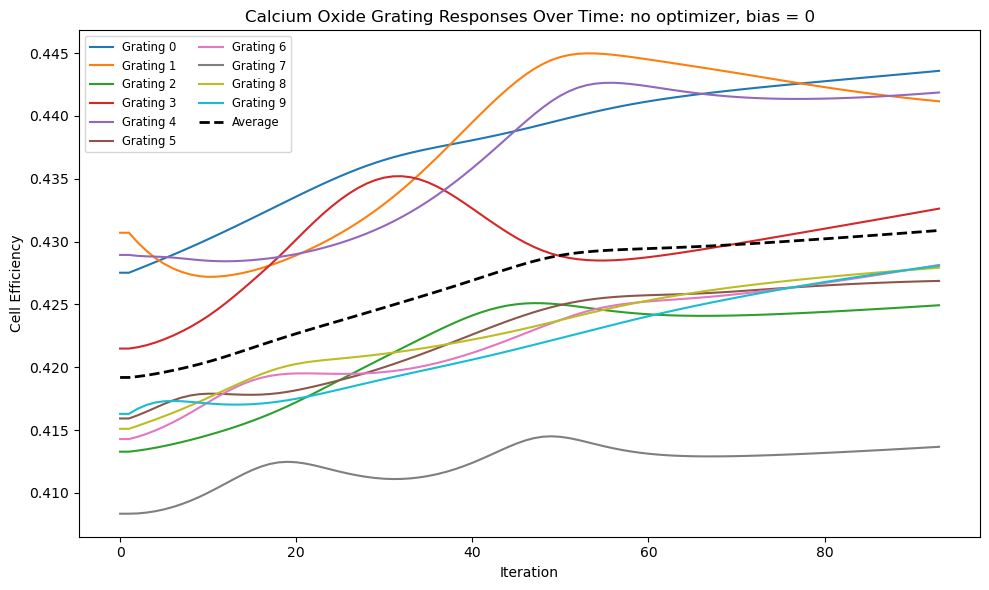

0.00012300952027241344 increase


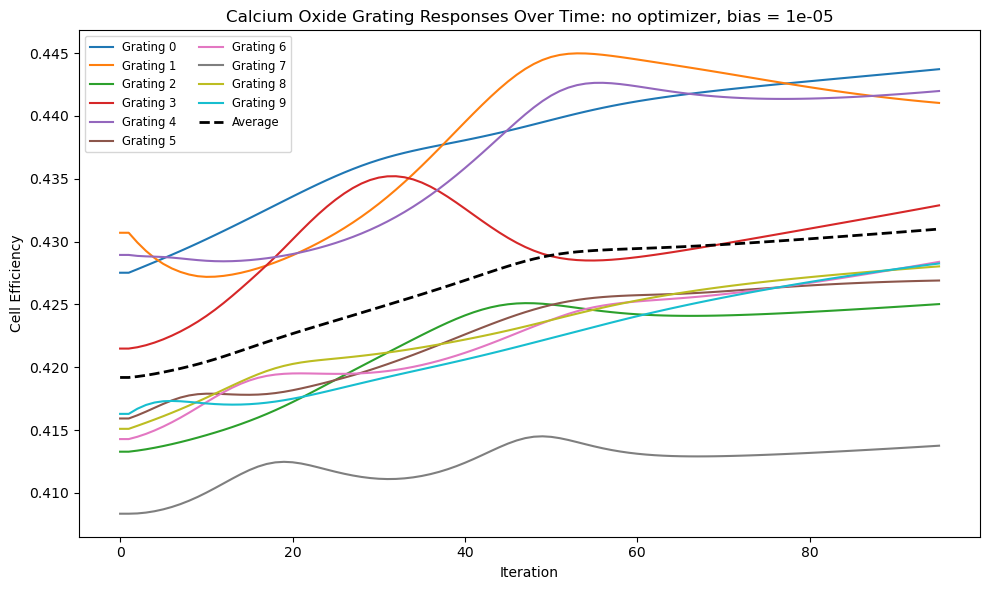

0.00012410377201281097 increase


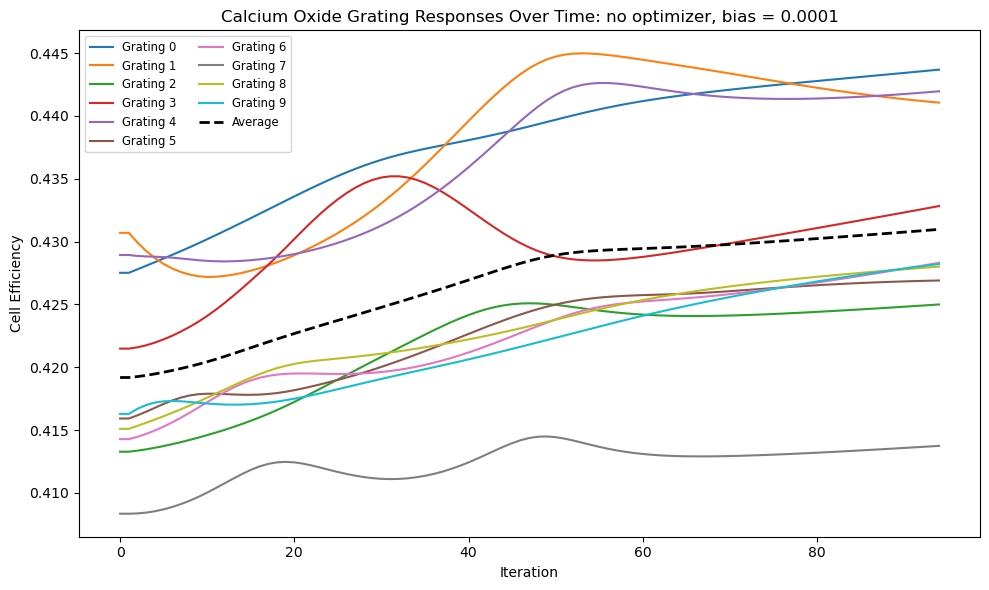

0.00012633225747517155 increase


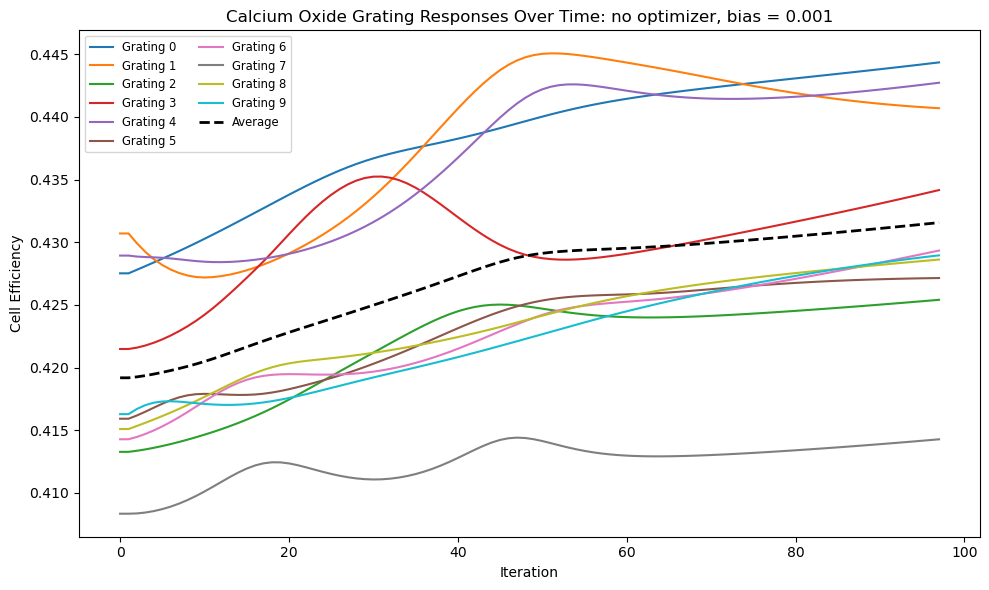

8.07372565121972e-06 increase


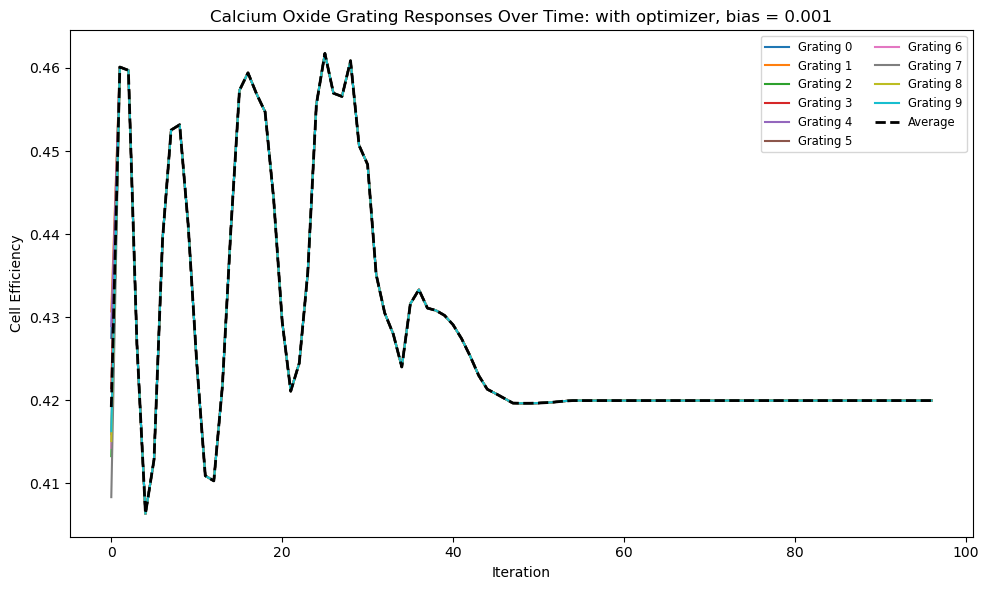

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_index_outputs_with_average(filename, optimizer, bias):
    # 1) Parse into a dict: grating_id → list of values
    data = {}
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or ':' not in line:
                continue
            i_str, v_str = line.split(':', 1)
            i, v = int(i_str), float(v_str)
            data.setdefault(i, []).append(v)

    # 2) Find the shortest series length
    # min_len = min(len(vals) for vals in data.values())
    # keep only gratings with at least N entries
    data = {idx: vals for idx, vals in data.items() if len(vals) >= 1}
    min_len = min(len(vals) for vals in data.values())
    # ... then slice [:min_len] as before

    # 3) Build a 2D array (iterations × gratings), ordered by grating ID
    gr_ids = sorted(data)
    # each row = one iteration across all gratings
    arr = np.vstack([data[g][:min_len] for g in gr_ids]).T

    # 4) Plot
    t = np.arange(min_len)
    fig, ax = plt.subplots(figsize=(10, 6))
    for col_idx, g in enumerate(gr_ids):
        ax.plot(t, arr[:, col_idx], label=f'Grating {g}')
    avg = arr.mean(axis=1)
    print(f'{(-avg[0]+avg[-1])/min_len} increase')

    ax.plot(t, avg, linestyle='--', linewidth=2,
            color='black', label='Average')
    ax.set(xlabel='Iteration',
           ylabel='Cell Efficiency',
           title=f'Calcium Oxide Grating Responses Over Time: {"no" if not optimizer else "with"} optimizer, bias: {bias}')
    ax.legend(ncol=2, fontsize='small')
    fig.tight_layout()
    plt.show()

a="e0ca48e1"
b="e192cc5d"
c="a3ab4398"
d="947def7b"
e="3015e2ff"
f="491513a7"
plot_index_outputs_with_average(f'../logs/gradient-descent-on-grating-t/def-{a}/fom_values.txt', optimizer = False, bias = 0)
plot_index_outputs_with_average(f'../logs/gradient-descent-on-grating-t/def-{b}/fom_values.txt', optimizer = False, bias = 1e-5)
plot_index_outputs_with_average(f'../logs/gradient-descent-on-grating-t/def-{c}/fom_values.txt', optimizer = False, bias = 1e-4)
plot_index_outputs_with_average(f'../logs/gradient-descent-on-grating-t/def-{d}/fom_values.txt', optimizer = False, bias = 1e-3)
plot_index_outputs_with_average(f'../logs/gradient-descent-on-grating-t/def-{f}/fom_values.txt', optimizer = True, bias = 1e-3)

In [24]:
import numpy as np

# ── USER CONFIG ────────────────────────────────────────────────────────────────
n_elements   = 22   # number of numbers per grating (your config['n_grating_elements'])
n_gratings   = 10   # number of gratings saved each epoch (config['n_gratings'])
# ────────────────────────────────────────────────────────────────────────────────

# load all floats from the file (one number per line)
# with open(f'../logs/gradient-descent-on-grating-t/def-{f}/image_values.txt', 'r') as f:
with open(f'../logs/gradient-descent-on-grating-t/def-491513a7/image_values.txt', 'r') as f:
    data = [float(line.strip()) for line in f if line.strip()]

total = len(data)
per_epoch = n_elements * n_gratings

if total % per_epoch != 0:
    raise ValueError(f"Total entries ({total}) is not a multiple of "
                     f"n_elements*n_gratings ({per_epoch})")

n_epochs = total // per_epoch

# convert flat list → NumPy and reshape
arr = np.array(data, dtype=float)

# first reshape to (n_epochs, n_gratings, n_elements)
arr = arr.reshape(n_epochs, n_gratings, n_elements)

# then transpose to (n_elements, n_gratings, n_epochs)
arr = arr.transpose(2, 1, 0)

print(f"Loaded data into array of shape {arr.shape}")
# arr[i, j, k] is element-i of grating-j at epoch-k


Loaded data into array of shape (22, 10, 94)


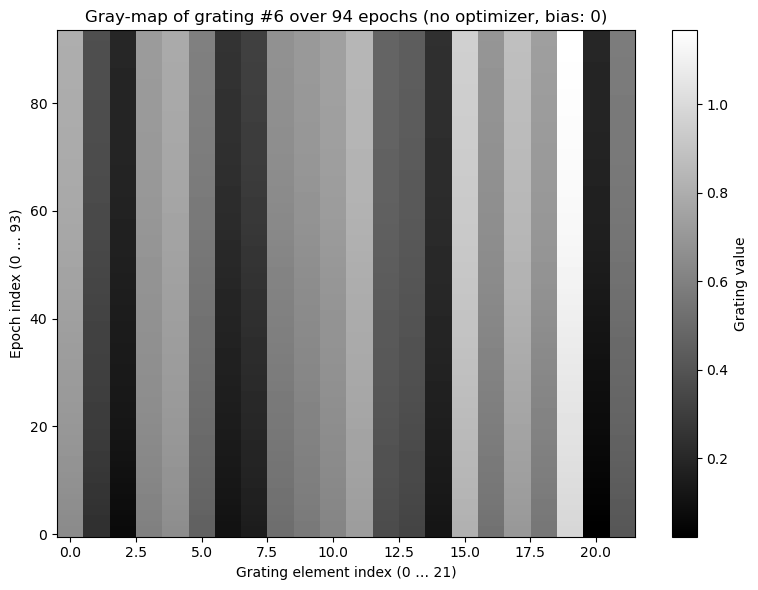

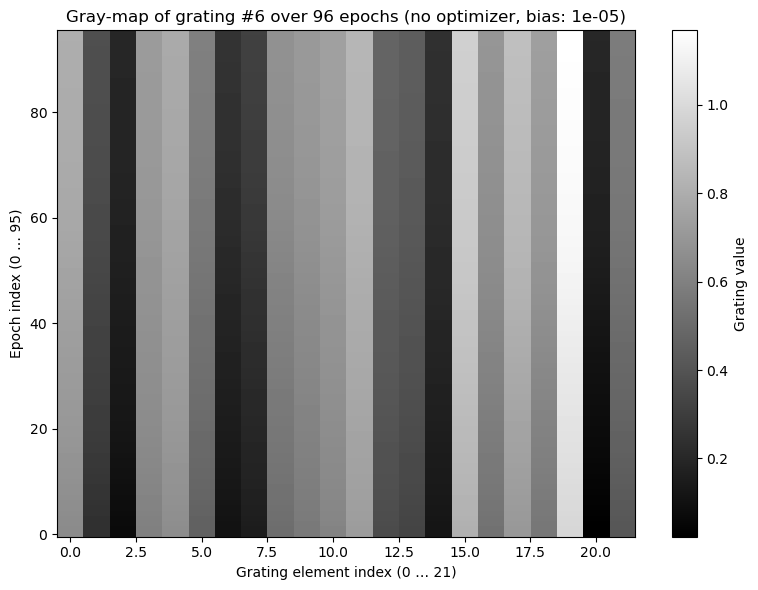

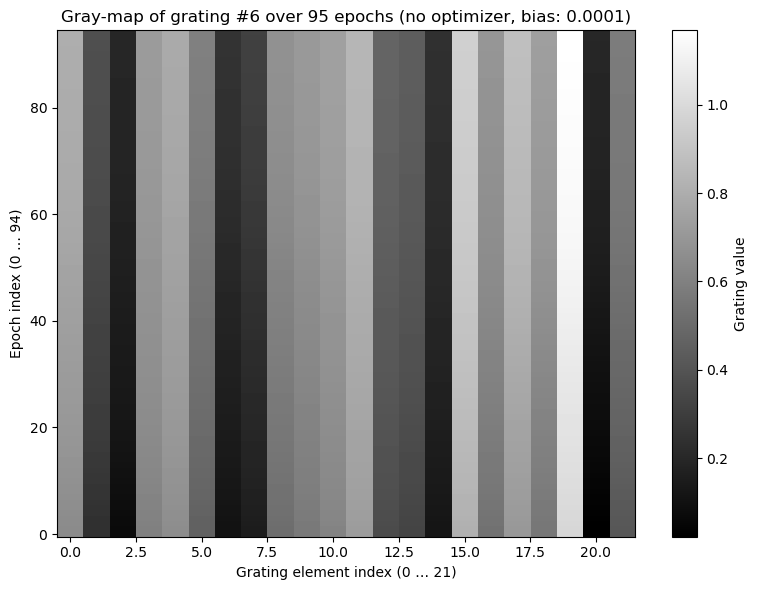

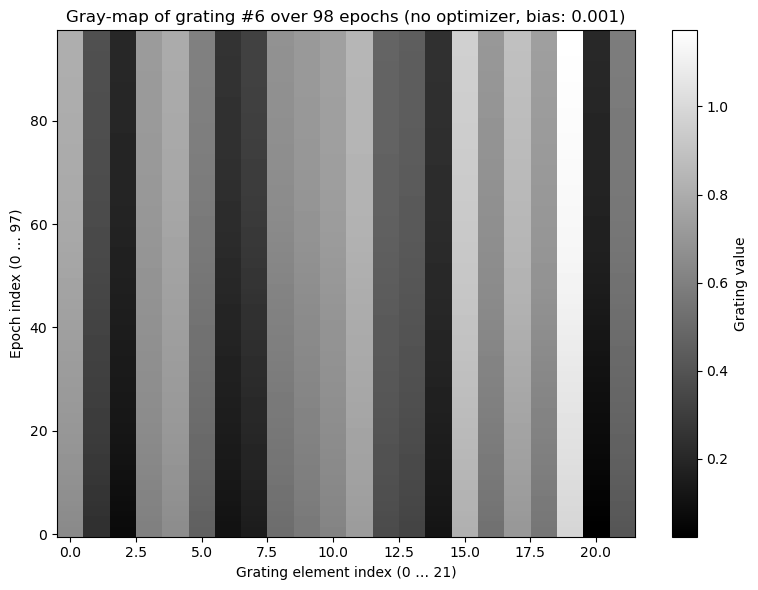

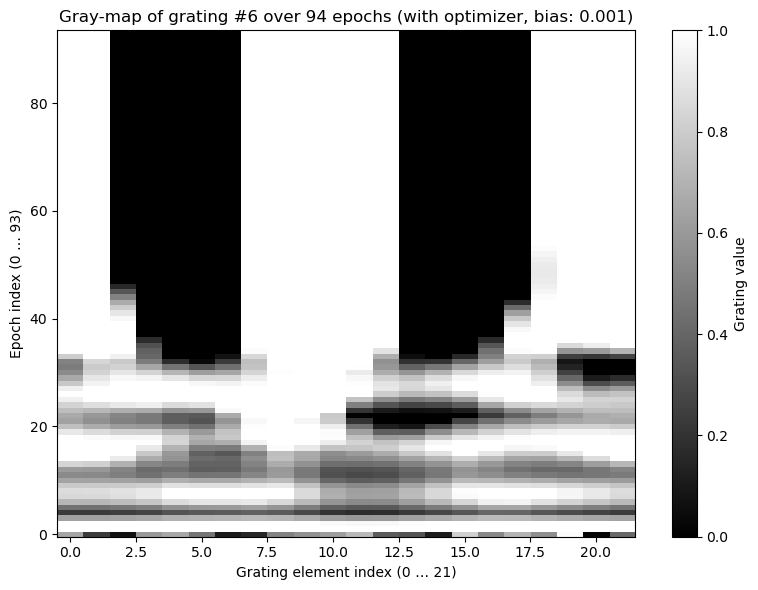

In [29]:
import numpy as np
import matplotlib.pyplot as plt

i = 0
optimizers = [0, 0, 0, 0, 1]
biases = [0, 1e-5, 1e-4, 1e-3, 1e-3]
for ele in [a,b,c,d,'491513a7']:

    # ── USER CONFIG ────────────────────────────────────────────────────────────────
    image_file   = f'../logs/gradient-descent-on-grating-t/def-{ele}/image_values.txt'  # your logged values (one float per line)
    n_elements   = 22                  # config['n_grating_elements']
    n_gratings   = 10                  # config['n_gratings']
    grating_idx  = 6                   # which grating (0-based) to plot
    # ────────────────────────────────────────────────────────────────────────────────

    # 1) Load all floats
    with open(image_file, 'r') as f:
        flat = [float(line.strip()) for line in f if line.strip()]

    # 2) Compute number of epochs
    per_epoch = n_elements * n_gratings
    if len(flat) % per_epoch != 0:
        raise ValueError(f"{len(flat)} entries is not a multiple of "
                        f"{per_epoch} = {n_elements}×{n_gratings}")
    n_epochs = len(flat) // per_epoch

    # 3) Group into (n_epochs, n_gratings, n_elements)
    data = np.array(flat, dtype=float)
    data = data.reshape(n_epochs, n_gratings, n_elements)

    # 4) Transpose to (n_elements, n_gratings, n_epochs)
    arr = data.transpose(2, 1, 0)

    # 5) Extract the i'th grating over time: shape (n_elements, n_epochs) → transpose → (n_epochs, n_elements)
    greymap = arr[:, grating_idx, :].T

    # 6) Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(
        greymap,
        cmap='gray',
        aspect='auto',
        origin='lower'  # epoch 0 at the bottom; use 'upper' if you prefer top-down
    )
    plt.xlabel('Grating element index (0 … {})'.format(n_elements-1))
    plt.ylabel('Epoch index (0 … {})'.format(n_epochs-1))
    plt.title(f'Gray-map of grating #{grating_idx} over {n_epochs} epochs ({"no" if not optimizers[i] else "with"} optimizer, bias: {biases[i]})')
    plt.colorbar(label='Grating value')
    plt.tight_layout()
    plt.show()
    i += 1
